# Exploratory data analysis
In this notebook we will analyze assay measurements and molecules for datasets from Chembl, DTC and Excape.
1. ***COPY*** this notebook into your own google drive. Work and edit from that one
2. Add the Columbia_E4511 folder to your google drive
3. For homework, you will work on this entire notebook for your own targets. Download them here:
  - https://www.ebi.ac.uk/chembl/
  - https://drugtargetcommons.fimm.fi/
  - https://solr.ideaconsult.net/search/excape/

In [1]:
#task: 1.compare Preposense Value

## Mount your drive where you have the Columbia_E4511 folder

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install packages

In [3]:
! pip install molvs

     |████████████████████████████████| 71kB 6.9MB/s 
  Created wheel for molvs: filename=MolVS-0.1.1-cp37-none-any.whl size=32376 sha256=81a2b4067e683a241ccfd7474f87511ebe7a84498895441fc59e436e0612b132
  Stored in directory: /root/.cache/pip/wheels/30/37/a8/8ac8147605c9de6b45ffd66d1cc19761d41467db12b34a0de8
Successfully built molvs


In [4]:
# thanks to https://web.navan.dev/posts/2020-07-01-Install-rdkit-colab/
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO


logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)


def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """

    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )

    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)

    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return

        logger.info("force re-install")

    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)

    logger.info("python version: {}".format(python_version))

    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)

    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')

    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')

    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python=={}".format(python_version),
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")

    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))


if __name__ == "__main__":
    install()

add /root/miniconda/lib/python3.7/site-packages to PYTHONPATH
python version: 3.7.10
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit
done
rdkit-2020.09.1 installation finished!


In [5]:
sys.path.append('/content/drive/MyDrive/Columbia_E4511/AMPL_EDA')
sys.path

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/root/miniconda/lib/python3.7/site-packages',
 '/content/drive/MyDrive/Columbia_E4511/AMPL_EDA']

## Load packages

In [6]:
%matplotlib inline
# manipulate data
import pandas as pd

# plot data
import numpy as np
import matplotlib.pyplot as plt

# curate data
import struct_utils
import curate_data
import dist_metrics

# visualize compound structures
import tempfile
from rdkit import Chem
from rdkit.Chem import Draw
from itertools import islice
from IPython.display import Image, display

# visualize data
import seaborn as sns
import matplotlib_venn as mpv
from scipy.stats import pearsonr

# set up visualization parameters
sns.set_context("paper")
sns.set_style("whitegrid")
sns.set_palette("Set2")
pal = sns.color_palette()
plt.rcParams['figure.figsize'] = [10,10]

pd.set_option('display.max_columns',(90))
pd.set_option('display.max_rows',(20))

## Load data

In [7]:
chembl = pd.read_csv("/content/drive/MyDrive/Columbia_E4511/HTR3A_ChEMBL.csv")
dtc = pd.read_csv("/content/drive/MyDrive/Columbia_E4511/HTR3A_DTC.csv")
excape = pd.read_csv("/content/drive/MyDrive/Columbia_E4511/HTR3A_Excape.csv")

In [8]:
#js
chembl = pd.read_csv("/content/drive/MyDrive/Columbia_E4511/CYP2D6_ChEMBL.csv")
dtc = pd.read_csv("/content/drive/MyDrive/Columbia_E4511/CYP2D6_DTC.csv")
excape = pd.read_csv("/content/drive/MyDrive/Columbia_E4511/CYP2D6_Excape.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (44) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,22,23,26) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Examine data
- what molecular (and other) identifiers exist for compounds from each database?
- what assay response types are there in each file?
- think about how we might combine these data sources together

chembl data

In [9]:
chembl.columns = chembl.columns.str.replace(' ','_') # get rid of annoying spaces
print(chembl.shape)

(32511, 45)


In [10]:
chembl.head()

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties
0,CHEMBL4454020,NaN,0.0,426.26,1,5.57,17,O=C(O)c1ccc(-n2cc(C(=O)c3c(Cl)cccc3Cl)c3ccccc3...,IC50,NaN,NaN,NaN,NaN,NaN,Not Determined,NaN,NaN,NaN,NaN,NaN,False,CHEMBL4349924,Inhibition of CYP2D6 in human liver microsomes...,A,BAO_0000251,microsome format,Homo sapiens,CHEMBL3559723,Liver,None,Microsomes,NaN,NaN,NaN,CHEMBL289,Cytochrome P450 2D6,Homo sapiens,SINGLE PROTEIN,CHEMBL4346735,1.0,Scientific Literature,Bioorg Med Chem Lett,2019.0,None,NaN
1,CHEMBL1398433,NaN,0.0,369.42,0,3.06,SID4238200,COc1ccc(NC(=O)N2CC3(CCN(C(=O)c4ccco4)CC3)C2)cc1,AC50,NaN,NaN,NaN,NaN,NaN,inactive,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1741321,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,BAO_0000019,assay format,None,None,None,None,None,NaN,NaN,NaN,CHEMBL289,Cytochrome P450 2D6,Homo sapiens,SINGLE PROTEIN,CHEMBL1201862,7.0,PubChem BioAssays,NaN,NaN,None,NaN
2,CHEMBL1333823,NaN,0.0,344.24,0,-1.12,SID4254274,O=C(O)c1nn(-c2ccccc2-c2nnc(O)nc2O)c(=O)[nH]c1=O,AC50,NaN,NaN,NaN,NaN,NaN,inconclusive,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1741321,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,BAO_0000019,assay format,None,None,None,None,None,NaN,NaN,NaN,CHEMBL289,Cytochrome P450 2D6,Homo sapiens,SINGLE PROTEIN,CHEMBL1201862,7.0,PubChem BioAssays,NaN,NaN,None,NaN
3,CHEMBL1436024,NaN,0.0,291.35,0,3.76,SID4240243,COc1cccc(-c2cc(NCc3ccccc3)ncn2)c1,AC50,'=',12589.25,nM,4.9,NaN,Active,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL1741321,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,BAO_0000019,assay format,None,None,None,None,None,NaN,NaN,NaN,CHEMBL289,Cytochrome P450 2D6,Homo sapiens,SINGLE PROTEIN,CHEMBL1201862,7.0,PubChem BioAssays,NaN,NaN,None,NaN
4,CHEMBL1613529,NaN,0.0,310.4,0,1.94,SID14740825,Cc1nnc(NC(=O)CCC(=O)NCc2cccs2)s1,AC50,NaN,NaN,NaN,NaN,NaN,inactive,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1741321,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,BAO_0000019,assay format,None,None,None,None,None,NaN,NaN,NaN,CHEMBL289,Cytochrome P450 2D6,Homo sapiens,SINGLE PROTEIN,CHEMBL1201862,7.0,PubChem BioAssays,NaN,NaN,None,NaN


In [11]:
chembl.Standard_Type.value_counts()

AC50                          17125
IC50                           6287
Potency                        3638
Inhibition                     2442
Ki                             1030
                              ...  
Fm                                1
Partition ratio                   1
Ks                                1
mechanism based inhibition        1
Activation                        1
Name: Standard_Type, Length: 34, dtype: int64

DTC data

In [12]:
dtc.columns = dtc.columns.str.replace(' ','_') # get rid of annoying spaces
print(dtc.shape)

(30057, 43)


In [13]:
dtc.head()

,Compound_ID,Uniprot_ID,Compound_Name,Standard_inchi_key,Max_Phase,Target_Pref_Name,Gene_Names,Target_Class,Wild_type_or_mutant,Mutation_information,PubMed_ID,End_Point_Standard_Type,End_Point_Standard_Relation,End_Point_Standard_Value,End_Point_Standard_Units,Endpoint_Mode_of_Action,Assay_Format,Assay_Type,Assay_Sub_Type,Inhibitor_Type,Detection_Technology,Compound_concentration_value,Compound_concentration_value_units,Substrate_type,Substrate_Type_Standard_Relation,Substrate_Type_Standard_Value,Substrate_Type_Standard_Units,Assay_cell_line,Assay_Description,Activity_Comments,Title,Journal,Year,Volume,Issue,Authors,Annotation_Comments,Assay_ID,DTC_Tid,DTC_Activity_ID,DTC_Molregno,Record_ID,DTC_Document_ID
0,CHEMBL1232461,AAAQFGUYHFJNHI-SFHVURJKSA-N,GSK525762A,NaN,P10635,CYTOCHROME P450 2D6,CYP2D6,NaN,NaN,NaN,24015967.0,IC50,>=,33000.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of human CYP2D6,Discovery of epigenetic regulator I-BET762: le...,J. Med. Chem.,PUBLICATION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CHEMBL1232461,AAAQFGUYHFJNHI-SFHVURJKSA-N,GSK525762A,NaN,P10635,CYTOCHROME P450 2D6,CYP2D6,NaN,NaN,NaN,24015967.0,INHIBITION,NaN,NaN,NaN,Not Active,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Time-dependent inhibition of human CYP2D6,Discovery of epigenetic regulator I-BET762: le...,J. Med. Chem.,PUBLICATION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CHEMBL1593731,AABYLPRACHMDSN-DDKMDXNESA-N,NaN,NaN,P10635,CYTOCHROME P450 2D6,CYP2D6,NaN,NaN,NaN,24015967.0,IC51,>=,33001.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,PUBCHEM BIOASSAY DATA SET,NaN,DATASET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CHEMBL1593731,AABYLPRACHMDSN-DDKMDXNESA-N,NaN,NaN,P10635,CYTOCHROME P450 2D6,CYP2D6,NaN,NaN,NaN,24015967.0,INHIBITION,NaN,NaN,NaN,Not Active,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PUBCHEM_BIOASSAY: qHTS Assay for Inhibitors an...,PUBCHEM BIOASSAY DATA SET,NaN,DATASET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CHEMBL1487748,AABYLPRACHMDSN-PVLDIMPDSA-N,NaN,NaN,P10635,CYTOCHROME P450 2D6,CYP2D6,NaN,NaN,NaN,24015967.0,IC52,>=,33002.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,PUBCHEM BIOASSAY DATA SET,NaN,DATASET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


excape data

In [14]:
excape.head()

,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES
0,PFNFFQXMRSDOHW-UHFFFAOYNA-N,1103,1565,N,NaN,pubchem,891,9606,CYP2D6,un13,N(CCCCNCCCN)CCCN
1,CJAWPFJGFFNXQI-UHFFFAOYNA-N,107992,1565,N,NaN,pubchem,891,9606,CYP2D6,un13,ClC1=NC(N2CCNCC2)=CN=C1
2,JSUAJTLKVREZHV-UHFFFAOYNA-N,5534,1565,N,NaN,pubchem,891,9606,CYP2D6,un13,N1(CCCC1)CC#CCN2CCCC2
3,RFBVBRVVOPAAFS-UHFFFAOYNA-N,322968,1565,N,NaN,pubchem,891,9606,CYP2D6,un13,O=C1C(N2CCC1CC2)(CO)CO
4,BMRGAJCUJCTATP-UHFFFAOYNA-N,96480,1565,N,NaN,pubchem,891,9606,CYP2D6,un13,OC=1C(=NC=CC1)CN2CCCCC2


In [15]:
excape[excape['pXC50'].notnull()]['pXC50']

7        5.70000
8        5.40000
9        5.70000
12       6.15490
13       5.24413
          ...   
13312    5.60000
13322    5.50000
13328    4.40000
13331    5.00000
13338    6.00000
Name: pXC50, Length: 7961, dtype: float64

## Exercise: Explore datasets
- load dtc and excape datasets with pandas
- explore the dataframes
- answer questions below

Number of data points in each file:

Molecular identifiers from each file:

Data types from each file:

Data units in each file:

What is the formula to translate IC50 to pIC50?

What other information might be useful?

In [16]:
# explore here

# EDA: assay data responses
- What type of variable are the data responses?
- What kind of ML model would you build to predict this data?
  regression
- What kind of visualizations & analysis can you use to understand more about the data?
  histogram...

In [17]:
chembl.head()

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties
0,CHEMBL4454020,NaN,0.0,426.26,1,5.57,17,O=C(O)c1ccc(-n2cc(C(=O)c3c(Cl)cccc3Cl)c3ccccc3...,IC50,NaN,NaN,NaN,NaN,NaN,Not Determined,NaN,NaN,NaN,NaN,NaN,False,CHEMBL4349924,Inhibition of CYP2D6 in human liver microsomes...,A,BAO_0000251,microsome format,Homo sapiens,CHEMBL3559723,Liver,None,Microsomes,NaN,NaN,NaN,CHEMBL289,Cytochrome P450 2D6,Homo sapiens,SINGLE PROTEIN,CHEMBL4346735,1.0,Scientific Literature,Bioorg Med Chem Lett,2019.0,None,NaN
1,CHEMBL1398433,NaN,0.0,369.42,0,3.06,SID4238200,COc1ccc(NC(=O)N2CC3(CCN(C(=O)c4ccco4)CC3)C2)cc1,AC50,NaN,NaN,NaN,NaN,NaN,inactive,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1741321,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,BAO_0000019,assay format,None,None,None,None,None,NaN,NaN,NaN,CHEMBL289,Cytochrome P450 2D6,Homo sapiens,SINGLE PROTEIN,CHEMBL1201862,7.0,PubChem BioAssays,NaN,NaN,None,NaN
2,CHEMBL1333823,NaN,0.0,344.24,0,-1.12,SID4254274,O=C(O)c1nn(-c2ccccc2-c2nnc(O)nc2O)c(=O)[nH]c1=O,AC50,NaN,NaN,NaN,NaN,NaN,inconclusive,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1741321,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,BAO_0000019,assay format,None,None,None,None,None,NaN,NaN,NaN,CHEMBL289,Cytochrome P450 2D6,Homo sapiens,SINGLE PROTEIN,CHEMBL1201862,7.0,PubChem BioAssays,NaN,NaN,None,NaN
3,CHEMBL1436024,NaN,0.0,291.35,0,3.76,SID4240243,COc1cccc(-c2cc(NCc3ccccc3)ncn2)c1,AC50,'=',12589.25,nM,4.9,NaN,Active,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL1741321,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,BAO_0000019,assay format,None,None,None,None,None,NaN,NaN,NaN,CHEMBL289,Cytochrome P450 2D6,Homo sapiens,SINGLE PROTEIN,CHEMBL1201862,7.0,PubChem BioAssays,NaN,NaN,None,NaN
4,CHEMBL1613529,NaN,0.0,310.4,0,1.94,SID14740825,Cc1nnc(NC(=O)CCC(=O)NCc2cccs2)s1,AC50,NaN,NaN,NaN,NaN,NaN,inactive,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1741321,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,BAO_0000019,assay format,None,None,None,None,None,NaN,NaN,NaN,CHEMBL289,Cytochrome P450 2D6,Homo sapiens,SINGLE PROTEIN,CHEMBL1201862,7.0,PubChem BioAssays,NaN,NaN,None,NaN


In [18]:
-np.log10(12589.25e-9)

4.900000142057633

In [19]:
chembl.Standard_Units.unique()

array([nan, 'nM', '%', 'uM', "10'-4/min", 'mL/min.umol', 'min-1',
       'nmol/min', '1/min', 'mL.min-1.g-1', 'hr', 'uL/min', '/min', 'min',
       "10'3ml/min", 'pmol/min', 'ug.mL-1', 'nmol', 'mM'], dtype=object)

## **Curation step**: change units to be the same for all responses

In [20]:
# change uM to nM units so they're all the same
chembl['Standard_Value_nM'] = np.where(chembl.Standard_Units == 'uM',
                                           chembl.Standard_Value * 1000,
                                           chembl.Standard_Value)

## EDA: Summarize, describe, plot data for analysis

In [21]:
# summary statistics
chembl.describe()

,Molecule_Max_Phase,Standard_Value,pChEMBL_Value,Ligand_Efficiency_BEI,Assay_Variant_Accession,Assay_Variant_Mutation,Source_ID,Document_Year,Standard_Value_nM
count,32464.000000,1.734100e+04,11860.000000,150.000000,0.0,0.0,29516.000000,8748.000000,1.734100e+04
mean,0.375308,7.905773e+05,5.279615,15.871400,NaN,NaN,5.389484,2012.425126,7.908977e+05
std,1.143081,2.740079e+07,0.775075,6.376143,NaN,NaN,3.502950,4.541791,2.740078e+07
min,0.000000,-5.800000e+01,4.000000,4.530000,NaN,NaN,1.000000,1993.000000,-5.800000e+01
25%,0.000000,8.000000e+02,4.700000,11.282500,NaN,NaN,1.000000,2009.000000,1.122020e+03
50%,0.000000,7.943300e+03,5.100000,15.630000,NaN,NaN,7.000000,2012.000000,9.000000e+03
75%,0.000000,1.995262e+04,5.600000,18.697500,NaN,NaN,7.000000,2016.000000,1.995262e+04
max,4.000000,1.000000e+09,10.350000,51.070000,NaN,NaN,54.000000,2020.000000,1.000000e+09


- **Why do some columns seem numeric but not give mean, SD? Examine chembl csv file - answer is some 'None' entries**


In [22]:
chembl=chembl.replace('None',np.nan)

In [23]:
# even after removing None you have to recast the column as numeric
numeric_cols=['Molecule_Max_Phase',
       'Molecular_Weight', '#RO5_Violations', 'AlogP', 'Standard_Value_nM',
       'pChEMBL_Value', 'Ligand_Efficiency_BEI', 'Ligand_Efficiency_LE',
       'Ligand_Efficiency_LLE', 'Ligand_Efficiency_SEI']
for col in numeric_cols:
  chembl[col]=chembl[col].astype(float)

In [24]:
chembl.describe()

,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Standard_Value,pChEMBL_Value,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Assay_Variant_Accession,Assay_Variant_Mutation,Source_ID,Document_Year,Standard_Value_nM
count,32464.000000,32387.000000,32046.000000,32046.000000,1.734100e+04,11860.000000,150.000000,146.000000,146.000000,146.000000,0.0,0.0,29516.000000,8748.000000,1.734100e+04
mean,0.375308,370.293490,0.242464,3.239220,7.905773e+05,5.279615,15.871400,0.309726,1.707260,19.419110,NaN,NaN,5.389484,2012.425126,7.908977e+05
std,1.143081,118.233145,0.549558,1.695304,2.740079e+07,0.775075,6.376143,0.118659,1.854502,30.125055,NaN,NaN,3.502950,4.541791,2.740078e+07
min,0.000000,32.050000,0.000000,-13.050000,-5.800000e+01,4.000000,4.530000,0.090000,-3.770000,1.700000,NaN,NaN,1.000000,1993.000000,-5.800000e+01
25%,0.000000,298.370000,0.000000,2.280000,8.000000e+02,4.700000,11.282500,0.230000,0.282500,7.097500,NaN,NaN,1.000000,2009.000000,1.122020e+03
50%,0.000000,359.450000,0.000000,3.300000,7.943300e+03,5.100000,15.630000,0.310000,1.755000,10.370000,NaN,NaN,7.000000,2012.000000,9.000000e+03
75%,0.000000,427.935000,0.000000,4.300000,1.995262e+04,5.600000,18.697500,0.360000,2.972500,15.210000,NaN,NaN,7.000000,2016.000000,1.995262e+04
max,4.000000,2296.970000,4.000000,12.980000,1.000000e+09,10.350000,51.070000,0.940000,5.490000,206.760000,NaN,NaN,54.000000,2020.000000,1.000000e+09


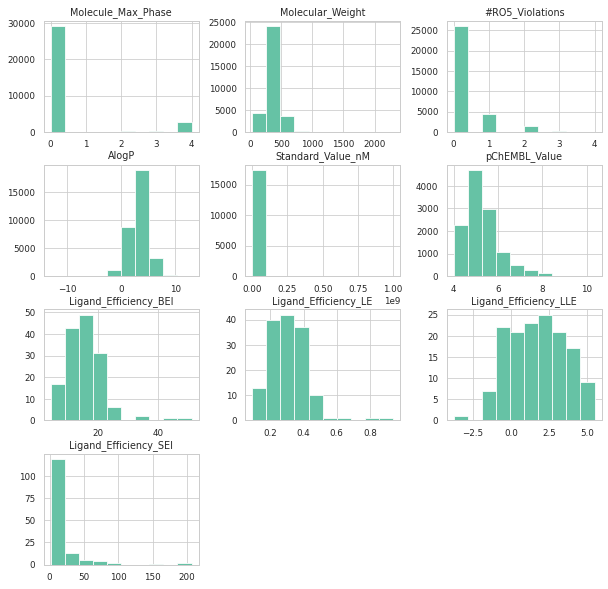

In [25]:
chembl[numeric_cols].hist(figsize=(10,10));

- **Note that pChembl value is better normalized than standard value**
- **Recall that there are lots of different activity types / assays represented in the value columns. Let's split those up:**

In [26]:
#chembl.head()

Standard_Type,AC50,Activation,Activity,CL,Compound recovery,Control of P-450 marker,Drug metabolism,EC50,FC,Fm,IC20,IC50,IC90,INH,Inhibition,Ki,Kinact,Km,Ks,PB,Partition ratio,Potency,Ratio,Ratio IC50,Retention_time,Stability,Stabilty,T1/2,TDI,Vmax,Vmax/Km
count,5.487000e+03,1.0,209.000000,4.000000,10.000000,1.0,49.000000,20.00000,151.000000,1.0,12.000000,4.890000e+03,7.0,247.000000,1545.000000,1.340000e+02,10.000000,9.000000,1.0,1.00,1.0,3360.000000,4.000000,22.000000,1.0,1.0,5.0,16.000000,12.000000,8.000000,1.000000
mean,2.201307e+06,50.0,1754.813732,1.171750,9.955000,102.0,32.740090,76357.00000,5.040397,2.6,15408.333333,8.501360e+04,100000.0,18554.655870,179.630290,8.070390e+04,2.375350,21076.851852,390.0,2.55,99.0,12770.709950,40.475000,3.822727,17.0,69.0,99.0,0.722691,8354.958333,30.450000,499.866667
std,4.573199e+07,NaN,8633.803699,1.441258,19.160212,NaN,33.830404,33993.04466,16.205271,NaN,17769.762792,1.451571e+06,0.0,19044.304353,2928.313206,2.046579e+05,7.176853,28721.482770,NaN,NaN,NaN,12090.781963,41.927348,4.950222,NaN,NaN,0.0,0.934259,19452.375829,49.796194,NaN
min,2.512000e+00,50.0,0.000000,0.003000,0.380000,102.0,-11.500000,4940.00000,0.200000,2.6,400.000000,0.000000e+00,100000.0,22.000000,-58.000000,0.000000e+00,0.026000,1400.000000,390.0,2.55,99.0,1.000000,3.000000,0.600000,17.0,69.0,99.0,0.025000,6.000000,2.425000,499.866667
25%,3.162280e+03,50.0,57.140000,0.026250,1.020000,102.0,3.700000,40000.00000,1.000000,2.6,2750.000000,4.800000e+03,100000.0,10000.000000,10.000000,1.000000e+03,0.037425,6350.000000,390.0,2.55,99.0,3162.300000,15.300000,2.000000,17.0,69.0,99.0,0.082080,20.000000,3.837500,499.866667
50%,1.000000e+04,50.0,88.100000,0.842000,1.525000,102.0,26.500000,100000.00000,1.000000,2.6,5000.000000,1.000000e+04,100000.0,10000.000000,23.000000,4.925000e+03,0.115000,9850.000000,390.0,2.55,99.0,8285.200000,29.950000,2.000000,17.0,69.0,99.0,0.250000,30.500000,4.912500,499.866667
75%,1.995262e+04,50.0,100.000000,1.987500,2.530000,102.0,53.500000,100000.00000,1.000000,2.6,29000.000000,3.000000e+04,100000.0,20000.000000,50.000000,3.680000e+04,0.177500,15650.000000,390.0,2.55,99.0,19952.600000,55.125000,2.600000,17.0,69.0,99.0,1.000000,42.500000,27.925000,499.866667
max,1.000000e+09,50.0,99000.000000,3.000000,57.220000,102.0,100.000000,100000.00000,120.700000,2.6,50000.000000,5.934779e+07,100000.0,100000.000000,89500.000000,1.122018e+06,22.800000,90000.000000,390.0,2.55,99.0,39810.700000,99.000000,21.000000,17.0,69.0,99.0,3.000000,50000.000000,140.000000,499.866667


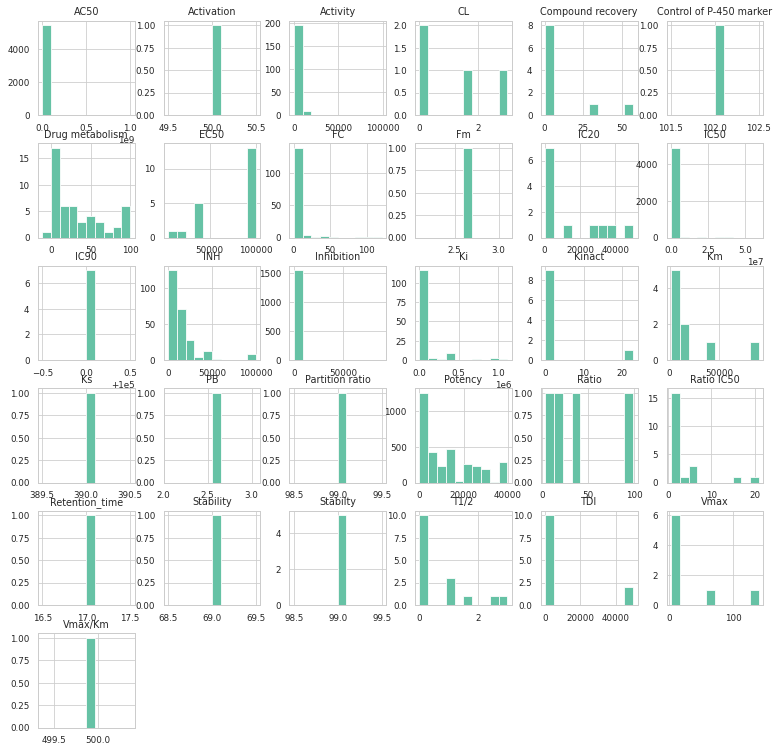

In [27]:
# examine standard values and pChembl values PER standard type
chembl_types=chembl.pivot_table(index = 'Molecule_ChEMBL_ID', columns = 'Standard_Type', values='Standard_Value_nM', aggfunc='mean')
display(chembl_types.describe())
chembl_types.hist(figsize=(13,13));

In [28]:
chembl_types

Standard_Type,AC50,Activation,Activity,CL,Compound recovery,Control of P-450 marker,Drug metabolism,EC50,FC,Fm,IC20,IC50,IC90,INH,Inhibition,Ki,Kinact,Km,Ks,PB,Partition ratio,Potency,Ratio,Ratio IC50,Retention_time,Stability,Stabilty,T1/2,TDI,Vmax,Vmax/Km
Molecule_ChEMBL_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CHEMBL10,39810.720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000.0,NaN,NaN,71.6,NaN,NaN,NaN,NaN,NaN,NaN,39810.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHEMBL10009,39810.720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39810.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHEMBL1002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1258.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHEMBL100473,15821.365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15821.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHEMBL1008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL98350,25118.860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25118.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHEMBL990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHEMBL991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- **What do you notice about the standard values?**

Standard_Type,AC50,EC50,IC50,Ki,Potency
count,5475.000000,3.000000,2212.000000,111.000000,3360.000000
mean,5.205279,4.790000,5.421238,5.588015,5.237971
std,0.711912,0.474658,0.826814,0.962402,0.732475
min,4.100000,4.380000,4.000000,4.000000,4.400000
25%,4.700000,4.530000,4.805000,5.000000,4.700000
50%,5.000000,4.680000,5.290000,5.500000,5.100000
75%,5.500000,4.995000,5.920000,6.085000,5.500000
max,8.600000,5.310000,10.350000,8.320000,9.000000


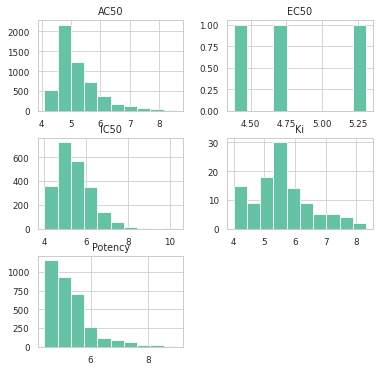

In [29]:
chembl_types=chembl.pivot_table(index = 'Molecule_ChEMBL_ID', columns = 'Standard_Type', values='pChEMBL_Value', aggfunc='mean')
display(chembl_types.describe())
chembl_types.hist(figsize=(6,6));

In [30]:
chembl_types

Standard_Type,AC50,EC50,IC50,Ki,Potency
Molecule_ChEMBL_ID,,,,,
CHEMBL10,4.4,NaN,5.70,NaN,4.4
CHEMBL10009,4.4,NaN,NaN,NaN,4.4
CHEMBL1002,NaN,NaN,NaN,NaN,5.9
CHEMBL100473,6.1,NaN,NaN,NaN,6.1
CHEMBL100917,NaN,NaN,4.50,NaN,NaN
...,...,...,...,...,...
CHEMBL97450,4.6,NaN,NaN,NaN,4.6
CHEMBL98350,4.6,NaN,NaN,NaN,4.6
CHEMBL990,NaN,NaN,6.52,NaN,NaN


- **What do you notice about the pChEMBL values?**

## Exercise: explore DTC and Excape data the same way
- **Curation step:** add pValue column from raw measurements if it doesn't exist

In [31]:
dtc.head()

,Compound_ID,Uniprot_ID,Compound_Name,Standard_inchi_key,Max_Phase,Target_Pref_Name,Gene_Names,Target_Class,Wild_type_or_mutant,Mutation_information,PubMed_ID,End_Point_Standard_Type,End_Point_Standard_Relation,End_Point_Standard_Value,End_Point_Standard_Units,Endpoint_Mode_of_Action,Assay_Format,Assay_Type,Assay_Sub_Type,Inhibitor_Type,Detection_Technology,Compound_concentration_value,Compound_concentration_value_units,Substrate_type,Substrate_Type_Standard_Relation,Substrate_Type_Standard_Value,Substrate_Type_Standard_Units,Assay_cell_line,Assay_Description,Activity_Comments,Title,Journal,Year,Volume,Issue,Authors,Annotation_Comments,Assay_ID,DTC_Tid,DTC_Activity_ID,DTC_Molregno,Record_ID,DTC_Document_ID
0,CHEMBL1232461,AAAQFGUYHFJNHI-SFHVURJKSA-N,GSK525762A,NaN,P10635,CYTOCHROME P450 2D6,CYP2D6,NaN,NaN,NaN,24015967.0,IC50,>=,33000.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of human CYP2D6,Discovery of epigenetic regulator I-BET762: le...,J. Med. Chem.,PUBLICATION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CHEMBL1232461,AAAQFGUYHFJNHI-SFHVURJKSA-N,GSK525762A,NaN,P10635,CYTOCHROME P450 2D6,CYP2D6,NaN,NaN,NaN,24015967.0,INHIBITION,NaN,NaN,NaN,Not Active,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Time-dependent inhibition of human CYP2D6,Discovery of epigenetic regulator I-BET762: le...,J. Med. Chem.,PUBLICATION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CHEMBL1593731,AABYLPRACHMDSN-DDKMDXNESA-N,NaN,NaN,P10635,CYTOCHROME P450 2D6,CYP2D6,NaN,NaN,NaN,24015967.0,IC51,>=,33001.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,PUBCHEM BIOASSAY DATA SET,NaN,DATASET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CHEMBL1593731,AABYLPRACHMDSN-DDKMDXNESA-N,NaN,NaN,P10635,CYTOCHROME P450 2D6,CYP2D6,NaN,NaN,NaN,24015967.0,INHIBITION,NaN,NaN,NaN,Not Active,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PUBCHEM_BIOASSAY: qHTS Assay for Inhibitors an...,PUBCHEM BIOASSAY DATA SET,NaN,DATASET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CHEMBL1487748,AABYLPRACHMDSN-PVLDIMPDSA-N,NaN,NaN,P10635,CYTOCHROME P450 2D6,CYP2D6,NaN,NaN,NaN,24015967.0,IC52,>=,33002.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,PUBCHEM BIOASSAY DATA SET,NaN,DATASET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
dtc['pDTC_Value'] = np.where(dtc.End_Point_Standard_Units == 'NM', -np.log10(dtc.End_Point_Standard_Value/1000000000), dtc.End_Point_Standard_Value)  #normalize

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [33]:
#dtc['End_Point_Standard_Units'].unique()

In [34]:
dtc.describe()

,Wild_type_or_mutant,Mutation_information,PubMed_ID,End_Point_Standard_Value,Inhibitor_Type,Year,Volume,Issue,Authors,Annotation_Comments,Assay_ID,DTC_Tid,DTC_Activity_ID,DTC_Molregno,Record_ID,DTC_Document_ID,pDTC_Value
count,0.0,0.0,7.130000e+03,1.622000e+04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.622000e+04
mean,NaN,NaN,2.110551e+07,8.477342e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
std,NaN,NaN,4.037276e+06,2.833178e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,-1.000000e+00,-5.800000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.800000e+01
25%,NaN,NaN,1.899601e+07,1.584900e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.698970e+00
50%,NaN,NaN,2.142219e+07,8.912510e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000e+00
75%,NaN,NaN,2.382721e+07,1.995262e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.699992e+00
max,NaN,NaN,2.929777e+07,1.000000e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf


In [35]:
#dtc.head()

End_Point_Standard_Type,AC50,ACTIVATION,ACTIVITY,Activity,CL,COMPOUND RECOVERY,CONTROL OF P-450 MARKER,DRUG METABOLISM,Drug metabolism,EC50,FM,IC20,IC50,IC51,IC52,IC53,IC90,INH,INHIBITION,Inhibition,KI,KINACT,KM,KS,PARTITION RATIO,PB,PIC50,POTENCY,RATIO,RATIO IC50,RETENTION_TIME,STABILITY,T1/2,TDI,VMAX,VMAX/KM
count,5.493000e+03,1.0,102.000000,6.000000,11.000000,25.000000,1.0,26.000000,2.000000,21.000000,1.0,13.000000,3.874000e+03,1.0,1.0,1.0,7.0,204.000000,1182.000000,45.000000,1.630000e+02,8.000000,14.000000,1.0,1.0,1.00,3.000000,3368.000000,2.000000,18.000000,1.0,2.000000,9.000000,3.0,12.000000,1.000000
mean,2.198919e+06,50.0,4920.517190,95.016667,9.361136,7.906000,102.0,37.532734,50.000000,72720.952381,2.6,15530.769231,1.157664e+05,33001.0,33002.0,33003.0,100000.0,16676.960784,226.752538,29.125000,6.647002e+04,2.958250,21756.547619,390.0,99.0,2.55,68.033333,12790.413953,51.000000,2.366667,17.0,79.500000,0.382956,39.0,483.266667,499.866667
std,4.570706e+07,NaN,14499.529983,7.208167,21.951500,22.689969,NaN,41.160540,50.440284,33546.809372,NaN,17018.978848,1.685568e+06,NaN,NaN,NaN,0.0,13692.493634,3346.779401,26.420205,1.879634e+05,8.017601,27852.293975,NaN,NaN,NaN,55.367891,12100.904005,67.882251,1.272792,NaN,14.849242,0.456359,7.0,1573.673239,NaN
min,2.510000e+00,50.0,0.000000,82.200000,0.003000,0.000000,102.0,0.010000,14.333333,4940.000000,2.6,400.000000,0.000000e+00,33001.0,33002.0,33003.0,100000.0,22.000000,-58.000000,0.000000,1.300000e+00,0.026000,1400.000000,390.0,99.0,2.55,4.100000,1.000000,3.000000,0.600000,17.0,69.000000,0.025000,31.0,2.425000,499.866667
25%,3.162280e+03,50.0,0.000000,92.725000,0.050000,0.000000,102.0,1.250000,32.166667,40000.000000,2.6,3000.000000,3.890000e+03,33001.0,33002.0,33003.0,100000.0,9125.000000,10.000000,6.600000,2.007143e+02,0.075000,5075.000000,390.0,99.0,2.55,52.050000,3162.300000,27.000000,2.000000,17.0,74.250000,0.066700,36.5,4.568750,499.866667
50%,1.000000e+04,50.0,62.070000,97.550000,1.650000,0.000000,102.0,23.200000,50.000000,100000.000000,2.6,5000.000000,1.000000e+04,33001.0,33002.0,33003.0,100000.0,13050.000000,23.000000,20.000000,3.000000e+03,0.155000,9650.000000,390.0,99.0,2.55,100.000000,8758.750000,51.000000,2.000000,17.0,79.500000,0.083300,42.0,11.400000,499.866667
75%,1.995262e+04,50.0,697.500000,99.075000,5.100000,1.170000,102.0,88.250000,67.833333,100000.000000,2.6,27000.000000,3.000000e+04,33001.0,33002.0,33003.0,100000.0,20000.000000,50.000000,44.000000,2.050000e+04,0.192500,21912.500000,390.0,99.0,2.55,100.000000,19952.600000,75.000000,2.000000,17.0,84.750000,0.967000,43.0,49.750000,499.866667
max,1.000000e+09,50.0,99000.000000,102.100000,74.400000,98.100000,102.0,100.000000,85.666667,100000.000000,2.6,50000.000000,5.934779e+07,33001.0,33002.0,33003.0,100000.0,100000.000000,89500.000000,94.625000,1.122018e+06,22.800000,90000.000000,390.0,99.0,2.55,100.000000,39810.700000,99.000000,5.000000,17.0,90.000000,1.000000,44.0,5478.700000,499.866667


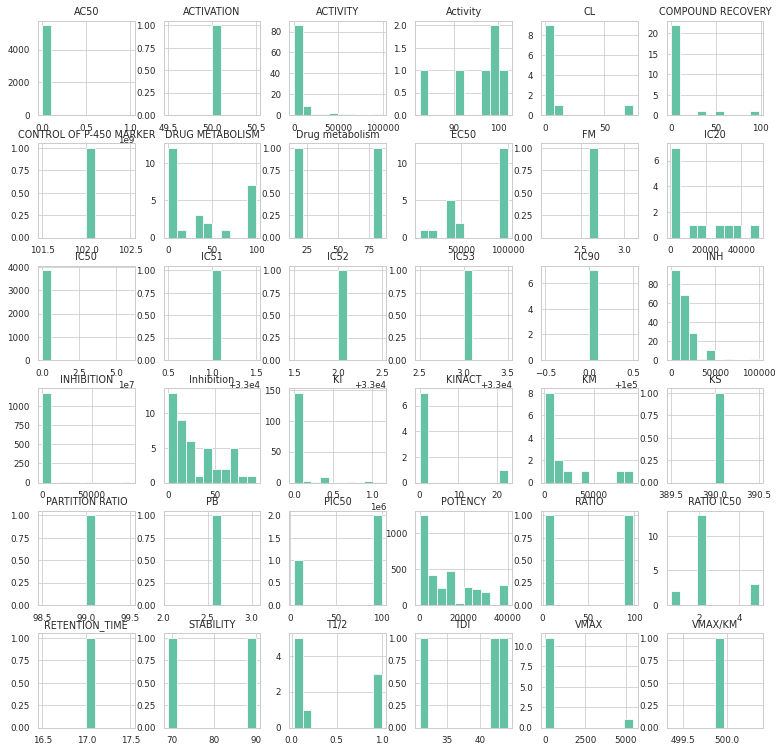

In [36]:
dtc_types=dtc.pivot_table(index = 'Compound_ID', columns = 'End_Point_Standard_Type', values='End_Point_Standard_Value', aggfunc='mean')
display(dtc_types.describe())
dtc_types.hist(figsize=(13,13));

In [37]:
dtc_types=dtc.pivot_table(index = 'Compound_ID', columns = 'End_Point_Standard_Type', values='pDTC_Value', aggfunc='mean')
display(dtc_types.describe())
#dtc_types.hist(figsize=(10,10));

End_Point_Standard_Type,AC50,ACTIVATION,ACTIVITY,Activity,CL,COMPOUND RECOVERY,CONTROL OF P-450 MARKER,DRUG METABOLISM,Drug metabolism,EC50,FM,IC20,IC50,IC51,IC52,IC53,IC90,INH,INHIBITION,Inhibition,KI,KINACT,KM,KS,PARTITION RATIO,PB,PIC50,POTENCY,RATIO,RATIO IC50,RETENTION_TIME,STABILITY,T1/2,TDI,VMAX,VMAX/KM
count,5493.000000,1.0,102.000000,6.000000,11.000000,25.000000,1.0,26.000000,2.000000,21.000000,1.0,13.000000,3874.000000,1.000000,1.00000,1.000000,7.0,204.000000,1182.000000,45.000000,163.000000,8.000000,14.000000,1.000000,1.0,1.00,3.000000,3368.000000,2.000000,18.000000,1.0,2.000000,9.000000,3.0,12.000000,1.000000
mean,5.194223,50.0,26.435320,95.016667,9.361136,7.906000,102.0,37.532734,50.000000,4.217285,2.6,5.184055,inf,4.481473,4.48146,4.481447,4.0,5.989599,32.016426,29.125000,5.665030,2.958250,5.018406,6.408935,99.0,2.55,68.033333,5.238092,51.000000,2.366667,17.0,79.500000,0.382956,39.0,483.266667,499.866667
std,0.752962,NaN,36.712697,7.208167,21.951500,22.689969,NaN,41.160540,50.440284,0.326897,NaN,0.697060,NaN,NaN,NaN,NaN,0.0,7.935267,27.973507,26.420205,1.419852,8.017601,0.529971,NaN,NaN,NaN,55.367891,0.734369,67.882251,1.272792,NaN,14.849242,0.456359,7.0,1573.673239,NaN
min,0.000000,50.0,0.000000,82.200000,0.003000,0.000000,102.0,0.010000,14.333333,4.000000,2.6,4.301030,1.397940,4.481473,4.48146,4.481447,4.0,4.000000,-58.000000,0.000000,2.950000,0.026000,4.045757,6.408935,99.0,2.55,4.100000,4.400000,3.000000,0.600000,17.0,69.000000,0.025000,31.0,2.425000,499.866667
25%,4.700000,50.0,0.000000,92.725000,0.050000,0.000000,102.0,1.250000,32.166667,4.000000,2.6,4.568636,4.522879,4.481473,4.48146,4.481447,4.0,4.698970,10.000000,6.600000,4.688375,0.075000,4.697189,6.408935,99.0,2.55,52.050000,4.700001,27.000000,2.000000,17.0,74.250000,0.066700,36.5,4.568750,499.866667
50%,5.000000,50.0,5.068339,97.550000,1.650000,0.000000,102.0,23.200000,50.000000,4.000000,2.6,5.301030,5.000000,4.481473,4.48146,4.481447,4.0,4.884393,22.000000,20.000000,5.522879,0.155000,5.159388,6.408935,99.0,2.55,100.000000,5.099999,51.000000,2.000000,17.0,79.500000,0.083300,42.0,11.400000,499.866667
75%,5.500000,50.0,44.812500,99.075000,5.100000,1.170000,102.0,88.250000,67.833333,4.397940,2.6,5.522879,5.431798,4.481473,4.48146,4.481447,4.0,5.039812,50.000000,44.000000,6.722745,0.192500,5.336198,6.408935,99.0,2.55,100.000000,5.499997,75.000000,2.000000,17.0,84.750000,0.967000,43.0,49.750000,499.866667
max,8.600326,50.0,104.140000,102.100000,74.400000,98.100000,102.0,100.000000,85.666667,5.306273,2.6,6.397940,inf,4.481473,4.48146,4.481447,4.0,94.000000,117.200000,94.625000,8.886057,22.800000,5.853872,6.408935,99.0,2.55,100.000000,9.000000,99.000000,5.000000,17.0,90.000000,1.000000,44.0,5478.700000,499.866667


,Entrez_ID,pXC50,Original_Assay_ID,Tax_ID
count,13341.0,7961.000000,1.334100e+04,13341.0
mean,1565.0,5.294766,3.995440e+05,9606.0
std,0.0,0.782885,3.635893e+05,0.0
min,1565.0,1.400000,8.910000e+02,9606.0
25%,1565.0,4.750000,8.910000e+02,9606.0
50%,1565.0,5.100000,5.601860e+05,9606.0
75%,1565.0,5.600000,7.378220e+05,9606.0
max,1565.0,10.350000,1.366896e+06,9606.0


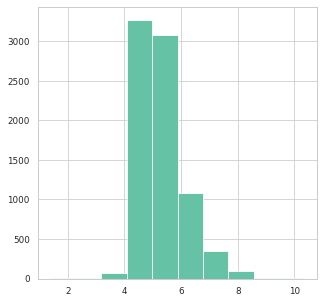

In [38]:
# excape only has one column we care about
display(excape.describe())
excape.pXC50.hist(figsize=(5,5));

## EDA & Exercise: compare pResponse values across all three datasets
- create a histogram or kde plot with legend showing distributions for all three datasets on the same plot

## Exercise: analyze & discuss
- what value types you would model and why?
- how would you use this data for a classification model?
- do any of the three datasets include a column you could use for classification?

# EDA: Compounds
- make sure smiles strings exist since that's what AMPL uses
- compare compounds in each dataset
- featurize with ECFP fingerprints
- examine diversity of compound set

## **Curation step** & exercise: Get SMILES for DTC data from chemical identifiers
Since AMPL and other modeling pipelines use SMILES strings, we will use these as our primary data curation tool.
1. open DTC file in google sheets / excel
2. copy/paste the compound ID (ChEMBLXXXXXXX) column into pubchem ID exchange service: https://pubchem.ncbi.nlm.nih.gov/idexchange/idexchange.cgi
  - did you get the whole column??
  - Be sure to select the correct registry ID for the input id list
  - Select "Same CID" and SMILES as output

6. upload resulting text file into Columbia_E4511 folder

In [39]:
# open file from pubchem ID exchange service
dtc_smiles = pd.read_csv("/content/drive/MyDrive/Columbia_E4511/3976943255867141171.txt", sep="\t", header=None)
dtc_smiles=dtc_smiles.rename(columns = {0:'ChEMBL_ID',1:'SMILES'})
dtc_smiles.head()

,ChEMBL_ID,SMILES
0,CHEMBL1232461,CCNC(=O)C[C@H]1C2=NN=C(N2C3=C(C=C(C=C3)OC)C(=N...
1,CHEMBL1232461,CCNC(=O)C[C@H]1C2=NN=C(N2C3=C(C=C(C=C3)OC)C(=N...
2,CHEMBL1593731,C[C@H]([C@H]1C[C@]1(C)[C@@H](C2=CC=CC=C2)NC(=O...
3,CHEMBL1593731,C[C@H]([C@H]1C[C@]1(C)[C@@H](C2=CC=CC=C2)NC(=O...
4,CHEMBL1487748,C[C@H]([C@@H]1C[C@@]1(C)[C@H](C2=CC=CC=C2)NC(=...


In [40]:
# map chembl id to smiles using a dict
dtc['SMILES'] = dtc['Compound_ID'].map(dict(zip(dtc_smiles.ChEMBL_ID, dtc_smiles.SMILES)))

In [41]:
dtc.head()

,Compound_ID,Uniprot_ID,Compound_Name,Standard_inchi_key,Max_Phase,Target_Pref_Name,Gene_Names,Target_Class,Wild_type_or_mutant,Mutation_information,PubMed_ID,End_Point_Standard_Type,End_Point_Standard_Relation,End_Point_Standard_Value,End_Point_Standard_Units,Endpoint_Mode_of_Action,Assay_Format,Assay_Type,Assay_Sub_Type,Inhibitor_Type,Detection_Technology,Compound_concentration_value,Compound_concentration_value_units,Substrate_type,Substrate_Type_Standard_Relation,Substrate_Type_Standard_Value,Substrate_Type_Standard_Units,Assay_cell_line,Assay_Description,Activity_Comments,Title,Journal,Year,Volume,Issue,Authors,Annotation_Comments,Assay_ID,DTC_Tid,DTC_Activity_ID,DTC_Molregno,Record_ID,DTC_Document_ID,pDTC_Value,SMILES
0,CHEMBL1232461,AAAQFGUYHFJNHI-SFHVURJKSA-N,GSK525762A,NaN,P10635,CYTOCHROME P450 2D6,CYP2D6,NaN,NaN,NaN,24015967.0,IC50,>=,33000.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of human CYP2D6,Discovery of epigenetic regulator I-BET762: le...,J. Med. Chem.,PUBLICATION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.481486,CCNC(=O)C[C@H]1C2=NN=C(N2C3=C(C=C(C=C3)OC)C(=N...
1,CHEMBL1232461,AAAQFGUYHFJNHI-SFHVURJKSA-N,GSK525762A,NaN,P10635,CYTOCHROME P450 2D6,CYP2D6,NaN,NaN,NaN,24015967.0,INHIBITION,NaN,NaN,NaN,Not Active,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Time-dependent inhibition of human CYP2D6,Discovery of epigenetic regulator I-BET762: le...,J. Med. Chem.,PUBLICATION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CCNC(=O)C[C@H]1C2=NN=C(N2C3=C(C=C(C=C3)OC)C(=N...
2,CHEMBL1593731,AABYLPRACHMDSN-DDKMDXNESA-N,NaN,NaN,P10635,CYTOCHROME P450 2D6,CYP2D6,NaN,NaN,NaN,24015967.0,IC51,>=,33001.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,PUBCHEM BIOASSAY DATA SET,NaN,DATASET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.481473,C[C@H]([C@H]1C[C@]1(C)[C@@H](C2=CC=CC=C2)NC(=O...
3,CHEMBL1593731,AABYLPRACHMDSN-DDKMDXNESA-N,NaN,NaN,P10635,CYTOCHROME P450 2D6,CYP2D6,NaN,NaN,NaN,24015967.0,INHIBITION,NaN,NaN,NaN,Not Active,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PUBCHEM_BIOASSAY: qHTS Assay for Inhibitors an...,PUBCHEM BIOASSAY DATA SET,NaN,DATASET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C[C@H]([C@H]1C[C@]1(C)[C@@H](C2=CC=CC=C2)NC(=O...
4,CHEMBL1487748,AABYLPRACHMDSN-PVLDIMPDSA-N,NaN,NaN,P10635,CYTOCHROME P450 2D6,CYP2D6,NaN,NaN,NaN,24015967.0,IC52,>=,33002.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,PUBCHEM BIOASSAY DATA SET,NaN,DATASET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.481460,C[C@H]([C@@H]1C[C@@]1(C)[C@H](C2=CC=CC=C2)NC(=...


In [42]:
# what's missing?
print("No ChemblID in DTC:", len(dtc[dtc['Compound_ID'].isna()]))
print("No SMILES from ChemblID in DTC:", len(dtc[dtc.SMILES.isna()]))

No ChemblID in DTC: 175
No SMILES from ChemblID in DTC: 390


## Exercise: try to recover the missing smiles from other chemical identifiers in the DTC file.

In [43]:
# try it yourself here  

## EDA: Examine compound overlaps
Start with questions you have about the compounds at this point in time, such as:
- what compounds are in each set? do they overlap?
- are the compounds diverse or all very similar to each other?

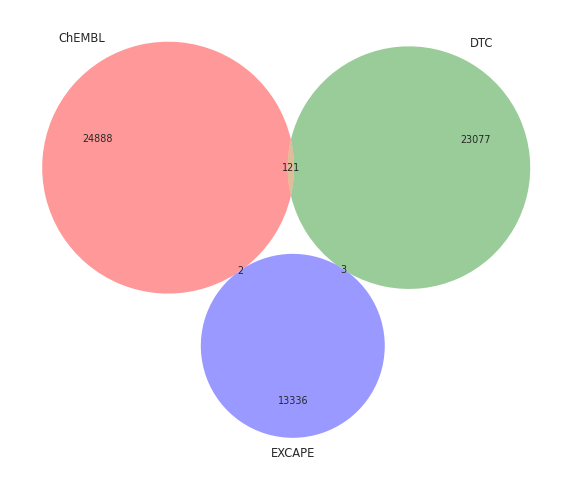

In [44]:
# overlaps from SMILES strings
mpv.venn3([set(chembl.Smiles),
           set(dtc.SMILES),
           set(excape.SMILES)],
          set_labels = ['ChEMBL', 'DTC','EXCAPE']);

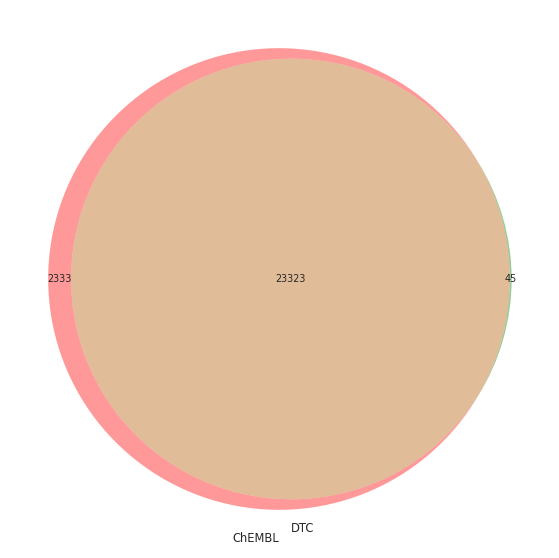

In [45]:
# venn diagram for overlapping ChEMBL IDs - mpv requires sets not lists
mpv.venn2([set(chembl.Molecule_ChEMBL_ID), set(dtc.Compound_ID)], set_labels=['ChEMBL','DTC']);

The chembl IDs overlap, why not the smiles strings? One explanation is that each database's SMILES string representations are slightly different. Answer? **STANDARDIZE the smiles strings.**

## **Curation step:** Standardize smiles strings, drop rows without base smiles

In [46]:
chembl['base_rdkit_smiles'] = chembl.Smiles.apply(struct_utils.base_smiles_from_smiles)
print(len(chembl.Smiles))
print(len(chembl.Smiles.unique()))
print(len(chembl.base_rdkit_smiles.unique()))

32511
25011
24918


In [47]:
chembl[chembl.base_rdkit_smiles=='']

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties,Standard_Value_nM,base_rdkit_smiles
117,CHEMBL1672962,NaN,0.0,447.58,0.0,4.98,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
143,CHEMBL605209,NaN,0.0,300.23,0.0,3.51,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
156,CHEMBL2208034,NaN,0.0,444.54,0.0,3.41,10d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
198,CHEMBL1210614,NaN,0.0,521.58,2.0,6.19,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
210,CHEMBL45244,PD-168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32453,CHEMBL3701697,NaN,0.0,355.48,0.0,3.10,(S)-13; NMS-P515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
32457,CHEMBL425519,NaN,0.0,193.25,0.0,3.26,Table 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
32458,CHEMBL178534,NaN,0.0,204.25,0.0,2.62,Table 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
32467,CHEMBL4592045,BTRX-335140,2.0,453.56,0.0,4.34,58; CYM-53093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,


In [48]:
chembl=chembl.replace('',np.nan)
chembl[chembl.base_rdkit_smiles.isna()]

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties,Standard_Value_nM,base_rdkit_smiles
117,CHEMBL1672962,NaN,0.0,447.58,0.0,4.98,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143,CHEMBL605209,NaN,0.0,300.23,0.0,3.51,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
156,CHEMBL2208034,NaN,0.0,444.54,0.0,3.41,10d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
198,CHEMBL1210614,NaN,0.0,521.58,2.0,6.19,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
210,CHEMBL45244,PD-168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32453,CHEMBL3701697,NaN,0.0,355.48,0.0,3.10,(S)-13; NMS-P515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32457,CHEMBL425519,NaN,0.0,193.25,0.0,3.26,Table 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32458,CHEMBL178534,NaN,0.0,204.25,0.0,2.62,Table 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32467,CHEMBL4592045,BTRX-335140,2.0,453.56,0.0,4.34,58; CYM-53093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
chembl=chembl[~chembl.base_rdkit_smiles.isna()]

In [50]:
print(len(chembl.Smiles.unique()))

25010


In [51]:
#chembl

## Exercise: standardize other datasets
- what do you notice about the number of unique smiles strings before and after standardization?
- what does this mean for the nature of the compounds in a given dataset?
- hint: look at chemical identifiers that have the same base_rdkit_smiles, and the 'DB' column in excape

In [52]:
#dtc
dtc['base_rdkit_smiles'] = dtc.SMILES.apply(struct_utils.base_smiles_from_smiles)
print(len(dtc.SMILES))
print(len(dtc.SMILES.unique()))
print(len(dtc.base_rdkit_smiles.unique()))

30057
23201
23102


In [53]:
dtc[dtc.base_rdkit_smiles=='']

,Compound_ID,Uniprot_ID,Compound_Name,Standard_inchi_key,Max_Phase,Target_Pref_Name,Gene_Names,Target_Class,Wild_type_or_mutant,Mutation_information,PubMed_ID,End_Point_Standard_Type,End_Point_Standard_Relation,End_Point_Standard_Value,End_Point_Standard_Units,Endpoint_Mode_of_Action,Assay_Format,Assay_Type,Assay_Sub_Type,Inhibitor_Type,Detection_Technology,Compound_concentration_value,Compound_concentration_value_units,Substrate_type,Substrate_Type_Standard_Relation,Substrate_Type_Standard_Value,Substrate_Type_Standard_Units,Assay_cell_line,Assay_Description,Activity_Comments,Title,Journal,Year,Volume,Issue,Authors,Annotation_Comments,Assay_ID,DTC_Tid,DTC_Activity_ID,DTC_Molregno,Record_ID,DTC_Document_ID,pDTC_Value,SMILES,base_rdkit_smiles
87,NaN,ABZSPJVXTTUFAA-UHFFFAOYSA-N,NaN,NaN,P10635,CYTOCHROME P450 2D6,CYP2D6,NaN,NaN,NaN,-1.0,IC50,<,30.0,NM,NaN,NaN,binding,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.522879,NaN,
88,NaN,ABZSPJVXTTUFAA-UHFFFAOYSA-N,NaN,NaN,P10635,CYTOCHROME P450 2D6,CYP2D6,NaN,NaN,NaN,-1.0,IC50,=,5.5,NM,NaN,NaN,binding,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.259637,NaN,
89,NaN,ABZSPJVXTTUFAA-UHFFFAOYSA-N,NaN,NaN,P10635,CYTOCHROME P450 2D6,CYP2D6,NaN,NaN,NaN,-1.0,IC50,=,9.0,NM,NaN,NaN,binding,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.045757,NaN,
90,NaN,ABZSPJVXTTUFAA-UHFFFAOYSA-N,NaN,NaN,P10635,CYTOCHROME P450 2D6,CYP2D6,NaN,NaN,NaN,-1.0,IC50,=,30.0,NM,NaN,NaN,binding,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.522879,NaN,
91,NaN,ABZSPJVXTTUFAA-UHFFFAOYSA-N,NaN,NaN,P10635,CYTOCHROME P450 2D6,CYP2D6,NaN,NaN,NaN,-1.0,IC50,=,65.0,NM,NaN,NaN,binding,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.187087,NaN,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30040,CHEMBL414804,NaN,OXALIPLATIN,NaN,P10635,CYTOCHROME P450 2D6,CYP2D6,NaN,NaN,NaN,NaN,IC50,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,cell_based,NaN,NaN,NaN,NaN,BTI-TN-5B1-4,NaN,NaN,NaN,NaN,NaN,NaN,"DRUGMATRIX: CYP450, 2D6 enzyme inhibition (sub...",DrugMatrix in vitro pharmacology data,NaN,DATASET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
30041,CHEMBL414804,NaN,OXALIPLATIN,NaN,P10635,CYTOCHROME P450 2D6,CYP2D6,NaN,NaN,NaN,NaN,KI,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,cell_based,NaN,NaN,NaN,NaN,BTI-TN-5B1-4,NaN,NaN,NaN,NaN,NaN,NaN,"DRUGMATRIX: CYP450, 2D6 enzyme inhibition (sub...",DrugMatrix in vitro pharmacology data,NaN,DATASET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
30042,CHEMBL508338,NaN,THIOMERSAL,NaN,P10635,CYTOCHROME P450 2D6,CYP2D6,NaN,NaN,NaN,NaN,IC50,=,3000.0,NM,NaN,cell_based,NaN,NaN,NaN,NaN,BTI-TN-5B1-4,NaN,NaN,NaN,NaN,NaN,NaN,"DRUGMATRIX: CYP450, 2D6 enzyme inhibition (sub...",DrugMatrix in vitro pharmacology data,NaN,DATASET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.522879,NaN,
30043,CHEMBL508338,NaN,THIOMERSAL,NaN,P10635,CYTOCHROME P450 2D6,CYP2D6,NaN,NaN,NaN,NaN,KI,NaN,NaN,NaN,Note: corresponding IC50 reported as Active,cell_based,NaN,NaN,NaN,NaN,BTI-TN-5B1-4,NaN,NaN,NaN,NaN,NaN,NaN,"DRUGMATRIX: CYP450, 2D6 enzyme inhibition (sub...",DrugMatrix in vitro pharmacology data,NaN,DATASET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,


In [54]:
dtc=dtc.replace('',np.nan)
dtc[dtc.base_rdkit_smiles.isna()]

,Compound_ID,Uniprot_ID,Compound_Name,Standard_inchi_key,Max_Phase,Target_Pref_Name,Gene_Names,Target_Class,Wild_type_or_mutant,Mutation_information,PubMed_ID,End_Point_Standard_Type,End_Point_Standard_Relation,End_Point_Standard_Value,End_Point_Standard_Units,Endpoint_Mode_of_Action,Assay_Format,Assay_Type,Assay_Sub_Type,Inhibitor_Type,Detection_Technology,Compound_concentration_value,Compound_concentration_value_units,Substrate_type,Substrate_Type_Standard_Relation,Substrate_Type_Standard_Value,Substrate_Type_Standard_Units,Assay_cell_line,Assay_Description,Activity_Comments,Title,Journal,Year,Volume,Issue,Authors,Annotation_Comments,Assay_ID,DTC_Tid,DTC_Activity_ID,DTC_Molregno,Record_ID,DTC_Document_ID,pDTC_Value,SMILES,base_rdkit_smiles
87,NaN,ABZSPJVXTTUFAA-UHFFFAOYSA-N,NaN,NaN,P10635,CYTOCHROME P450 2D6,CYP2D6,NaN,NaN,NaN,-1.0,IC50,<,30.0,NM,NaN,NaN,binding,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.522879,NaN,NaN
88,NaN,ABZSPJVXTTUFAA-UHFFFAOYSA-N,NaN,NaN,P10635,CYTOCHROME P450 2D6,CYP2D6,NaN,NaN,NaN,-1.0,IC50,=,5.5,NM,NaN,NaN,binding,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.259637,NaN,NaN
89,NaN,ABZSPJVXTTUFAA-UHFFFAOYSA-N,NaN,NaN,P10635,CYTOCHROME P450 2D6,CYP2D6,NaN,NaN,NaN,-1.0,IC50,=,9.0,NM,NaN,NaN,binding,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.045757,NaN,NaN
90,NaN,ABZSPJVXTTUFAA-UHFFFAOYSA-N,NaN,NaN,P10635,CYTOCHROME P450 2D6,CYP2D6,NaN,NaN,NaN,-1.0,IC50,=,30.0,NM,NaN,NaN,binding,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.522879,NaN,NaN
91,NaN,ABZSPJVXTTUFAA-UHFFFAOYSA-N,NaN,NaN,P10635,CYTOCHROME P450 2D6,CYP2D6,NaN,NaN,NaN,-1.0,IC50,=,65.0,NM,NaN,NaN,binding,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.187087,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30040,CHEMBL414804,NaN,OXALIPLATIN,NaN,P10635,CYTOCHROME P450 2D6,CYP2D6,NaN,NaN,NaN,NaN,IC50,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,cell_based,NaN,NaN,NaN,NaN,BTI-TN-5B1-4,NaN,NaN,NaN,NaN,NaN,NaN,"DRUGMATRIX: CYP450, 2D6 enzyme inhibition (sub...",DrugMatrix in vitro pharmacology data,NaN,DATASET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30041,CHEMBL414804,NaN,OXALIPLATIN,NaN,P10635,CYTOCHROME P450 2D6,CYP2D6,NaN,NaN,NaN,NaN,KI,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,cell_based,NaN,NaN,NaN,NaN,BTI-TN-5B1-4,NaN,NaN,NaN,NaN,NaN,NaN,"DRUGMATRIX: CYP450, 2D6 enzyme inhibition (sub...",DrugMatrix in vitro pharmacology data,NaN,DATASET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30042,CHEMBL508338,NaN,THIOMERSAL,NaN,P10635,CYTOCHROME P450 2D6,CYP2D6,NaN,NaN,NaN,NaN,IC50,=,3000.0,NM,NaN,cell_based,NaN,NaN,NaN,NaN,BTI-TN-5B1-4,NaN,NaN,NaN,NaN,NaN,NaN,"DRUGMATRIX: CYP450, 2D6 enzyme inhibition (sub...",DrugMatrix in vitro pharmacology data,NaN,DATASET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.522879,NaN,NaN
30043,CHEMBL508338,NaN,THIOMERSAL,NaN,P10635,CYTOCHROME P450 2D6,CYP2D6,NaN,NaN,NaN,NaN,KI,NaN,NaN,NaN,Note: corresponding IC50 reported as Active,cell_based,NaN,NaN,NaN,NaN,BTI-TN-5B1-4,NaN,NaN,NaN,NaN,NaN,NaN,"DRUGMATRIX: CYP450, 2D6 enzyme inhibition (sub...",DrugMatrix in vitro pharmacology data,NaN,DATASET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
dtc=dtc[~dtc.base_rdkit_smiles.isna()]

In [ ]:
#excape
excape['base_rdkit_smiles'] = excape.SMILES.apply(struct_utils.base_smiles_from_smiles)
print(len(excape.SMILES))
print(len(excape.SMILES.unique()))
print(len(excape.base_rdkit_smiles.unique()))

13341
13341
13329


In [ ]:
excape[excape.base_rdkit_smiles=='']

,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES,base_rdkit_smiles
475,RRSCJMKFYYSZES-UHFFFAOYNA-N,172268,1565,N,NaN,pubchem,891,9606,CYP2D6,un13,ON=1(CCN=2(O)CCCCC2)CCCCC1,
953,NVYHVHVSHFOAPB-UHFFFAOYNA-N,224948,1565,N,NaN,pubchem,891,9606,CYP2D6,un13,ON(=CC=1C=C(C=CC1O)C2=CC=CC=C2)(C)C,
1036,QGTGMXPADSCUFS-KZFATGLANA-N,5351837,1565,N,NaN,pubchem,891,9606,CYP2D6,un13,ON(CCO)(=CCO)C1=NC=NC=2N=CNC12,
2084,TXACMWZLLJFLER-UHFFFAOYNA-N,20313,1565,N,NaN,pubchem,891,9606,CYP2D6,un13,ON(=CC=CC1C=2C(CCC=3C1=CC=CC3)=CC=CC2)(C)C,
6089,MXZASAPEQAUAEP-REUGXJQINA-N,5771580,1565,N,NaN,pubchem,891,9606,CYP2D6,un13,ON=1([C@@H]2CCC1CC(OC(=O)[C@@H](CO)C3=CC=CC=C3...,
6090,MXZASAPEQAUAEP-VADGTKANNA-N,3246272,1565,N,NaN,pubchem,891,9606,CYP2D6,un13,ON=1([C@H]2CCC1CC(OC(=O)[C@@H](CO)C3=CC=CC=C3)...,
10968,XBRDHOJWZLJOJV-IPPOASPLNA-N,6604327,1565,N,NaN,pubchem,891,9606,CYP2D6,un13,O1[C@H]2[C@@H]1[C@@H]3N(O)(=C2CC(OC(=O)[C@@H](...,
12266,XYBAFMNNAXYCSR-YOSCJVSPNA-N,3246431,1565,N,NaN,pubchem,891,9606,CYP2D6,un13,ON1=2[C@H]3[C@@]4([C@H](NC5=C4C=CC=C5)[C@@H]6[...,
12990,JJHSSWRMKZGFJZ-XRNRYIISNA-N,CHEMBL267548,1565,N,4.6,chembl20,737822,9606,CYP2D6,un13,C=1/2\N=C(C=C3N=C(/C=C/4\[NH2]C(=[C]C5=NC(/C1)...,


In [ ]:
excape=excape.replace('',np.nan)
excape[excape.base_rdkit_smiles.isna()]

,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES,base_rdkit_smiles
475,RRSCJMKFYYSZES-UHFFFAOYNA-N,172268,1565,N,NaN,pubchem,891,9606,CYP2D6,un13,ON=1(CCN=2(O)CCCCC2)CCCCC1,NaN
953,NVYHVHVSHFOAPB-UHFFFAOYNA-N,224948,1565,N,NaN,pubchem,891,9606,CYP2D6,un13,ON(=CC=1C=C(C=CC1O)C2=CC=CC=C2)(C)C,NaN
1036,QGTGMXPADSCUFS-KZFATGLANA-N,5351837,1565,N,NaN,pubchem,891,9606,CYP2D6,un13,ON(CCO)(=CCO)C1=NC=NC=2N=CNC12,NaN
2084,TXACMWZLLJFLER-UHFFFAOYNA-N,20313,1565,N,NaN,pubchem,891,9606,CYP2D6,un13,ON(=CC=CC1C=2C(CCC=3C1=CC=CC3)=CC=CC2)(C)C,NaN
6089,MXZASAPEQAUAEP-REUGXJQINA-N,5771580,1565,N,NaN,pubchem,891,9606,CYP2D6,un13,ON=1([C@@H]2CCC1CC(OC(=O)[C@@H](CO)C3=CC=CC=C3...,NaN
6090,MXZASAPEQAUAEP-VADGTKANNA-N,3246272,1565,N,NaN,pubchem,891,9606,CYP2D6,un13,ON=1([C@H]2CCC1CC(OC(=O)[C@@H](CO)C3=CC=CC=C3)...,NaN
10968,XBRDHOJWZLJOJV-IPPOASPLNA-N,6604327,1565,N,NaN,pubchem,891,9606,CYP2D6,un13,O1[C@H]2[C@@H]1[C@@H]3N(O)(=C2CC(OC(=O)[C@@H](...,NaN
12266,XYBAFMNNAXYCSR-YOSCJVSPNA-N,3246431,1565,N,NaN,pubchem,891,9606,CYP2D6,un13,ON1=2[C@H]3[C@@]4([C@H](NC5=C4C=CC=C5)[C@@H]6[...,NaN
12990,JJHSSWRMKZGFJZ-XRNRYIISNA-N,CHEMBL267548,1565,N,4.6,chembl20,737822,9606,CYP2D6,un13,C=1/2\N=C(C=C3N=C(/C=C/4\[NH2]C(=[C]C5=NC(/C1)...,NaN


In [ ]:
excape=excape[~excape.base_rdkit_smiles.isna()]

## **Curation step:** Save standardized datasets

In [ ]:
chembl.to_csv("/content/drive/MyDrive/Columbia_E4511/CYP2D6_ChEMBL_SMILES.csv")
dtc.to_csv("/content/drive/MyDrive/Columbia_E4511/CYP2D6_DTC_SMILES.csv")
excape.to_csv("/content/drive/MyDrive/Columbia_E4511/CYP2D6_Excape_SMILES.csv")

## Exercise: examine compound overlaps from standardized smiles strings
- create venn diagram with 3 circles for all 3 datasets

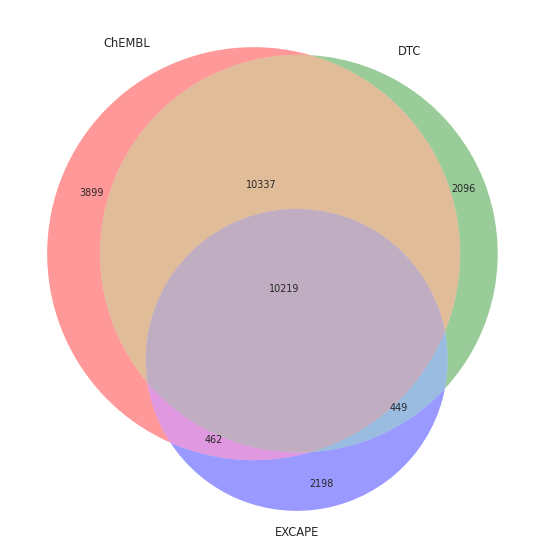

In [ ]:
#chembl
mpv.venn3([set(chembl.base_rdkit_smiles),
           set(dtc.base_rdkit_smiles),
           set(excape.base_rdkit_smiles)],
          set_labels = ['ChEMBL', 'DTC','EXCAPE']);

## EDA: Examine compound diversity

In [ ]:
import diversity_plots as dp
sns.set_context('poster')

2021-03-17 21:37:30,930 Starting distance matrix calculation for 31583 compounds
2021-03-17 21:43:44,163 Finished calculation of 498727153 distances


array([0.89156627, 0.82894737, 0.85185185, ..., 0.91764706, 0.8625    ,
       0.88157895])

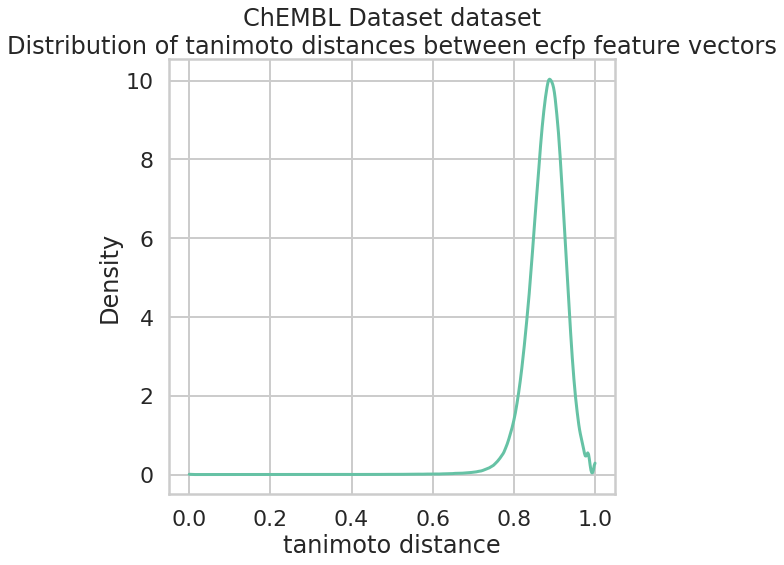

In [ ]:
dp.plot_tani_dist_distr(chembl, 'base_rdkit_smiles', 'ChEMBL Dataset')

In [ ]:
dp.diversity_plots('/content/drive/MyDrive/Columbia_E4511/CYP2D6_ChEMBL_SMILES.csv', 
                   id_col ='Molecule_ChEMBL_ID', smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, response_col = 'pChEMBL_Value')

## Exercise: create plots for DTC, Excape
- What happens when you change the ecfp radius?
- bonus: try creating MCS plots by looking at the documentation of the diversity_plots function
- warning: it is very slow for >1000 ish compounds. 
- extra bonus: select a random subset of 1000 compounds and create the MCS plots.

In [ ]:
dp.plot_tani_dist_distr(dtc, 'base_rdkit_smiles', 'ChEMBL Dataset')

In [ ]:
dp.diversity_plots('/content/drive/MyDrive/Columbia_E4511/CYP2D6_DTC_SMILES.csv', 
                   id_col ='Molecule_ChEMBL_ID', smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, response_col = 'pChEMBL_Value')

In [ ]:
dp.plot_tani_dist_distr(excape, 'base_rdkit_smiles', 'ChEMBL Dataset')

In [ ]:
dp.diversity_plots('/content/drive/MyDrive/Columbia_E4511/CYP2D6_Excape_SMILES.csv', 
                   id_col ='Molecule_ChEMBL_ID', smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, response_col = 'pChEMBL_Value')

## Exercise: analyze and discuss these plots.
- what are Morgan fingerprints (ecfp)? 
  - what does radius mean?
  - what does a bit in an ECFP vector correspond to?
  - what radius and vector length are used in these functions?
  - hint: look at the .py files for more info
- what is tanimoto distance? What do values closer to zero or closer to one mean?
- do you think your sets of compounds are diverse?
- what do you observe from the 2D projection of compounds?
- are there any similarities between groups of compounds in your datasets?